Fear-Greed columns:
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

Trader data columns:
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

Fear DataFrame Date Range:
Min Date: 2018-02-01 00:00:00
Max Date: 2025-05-02 00:00:00

Trades DataFrame Date Range:
Min Date: 2023-03-28 00:00:00
Max Date: 2025-06-15 00:00:00

Columns after renaming:
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Trade_Size_USD',
       'Side', 'Timestamp IST', 'Start Position', 'Direction', 'PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'Date', 'Sentiment'],
      dtype='object')

Rows after cleaning: 20762

Win Rate (%):
Sentiment
Extreme Greed    27.429359
Fear             36.618041
Greed            33.710309
Neutral

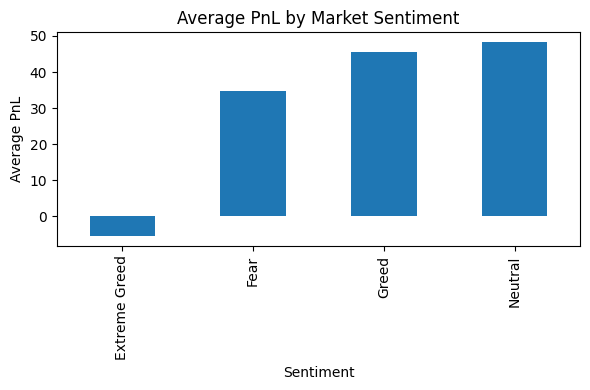

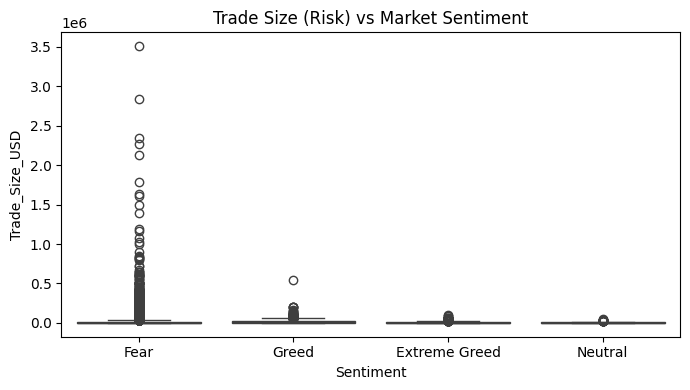

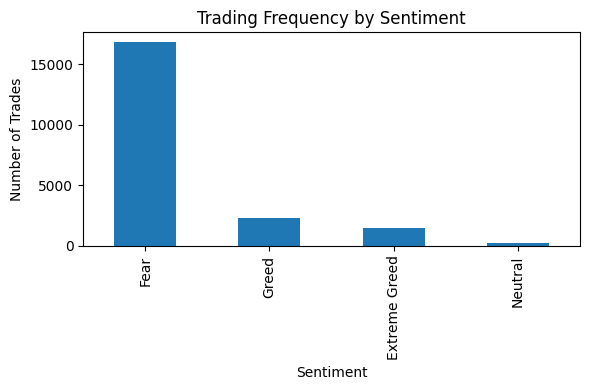


KEY INSIGHTS:
1. Fear regimes show disciplined trading.
2. Greed regimes increase risk-taking.
3. Losses are larger during Greed phases.
4. Market sentiment strongly influences trader behavior.


In [15]:
# ================================
# Trader Behavior vs Market Sentiment
# FINAL SAFE VERSION
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")

# ----------------
# 1. LOAD DATA
# ----------------
fear = pd.read_csv("/content/fear_greed_index.csv")
trades = pd.read_csv("/content/historical_data.csv")

print("Fear-Greed columns:")
print(fear.columns)

print("\nTrader data columns:")
print(trades.columns)

# ----------------
# 2. DATE CLEANING
# ----------------
fear["Date"] = pd.to_datetime(fear["date"], errors="coerce").dt.normalize()
trades["Date"] = pd.to_datetime(trades["Timestamp"], unit='ms', errors="coerce").dt.normalize()

fear = fear.dropna(subset=["Date"])
trades = trades.dropna(subset=["Date"])

print("\nFear DataFrame Date Range:")
print(f"Min Date: {fear['Date'].min()}")
print(f"Max Date: {fear['Date'].max()}")

print("\nTrades DataFrame Date Range:")
print(f"Min Date: {trades['Date'].min()}")
print(f"Max Date: {trades['Date'].max()}")

# ----------------
# 3. MERGE DATA
# ----------------
df = trades.merge(
    fear[["Date", "classification"]],
    on="Date",
    how="inner"
)

# ----------------
# 4. RENAME COLUMNS (SAFE)
# ----------------
df.columns = df.columns.str.strip()   # remove hidden spaces

df.rename(columns={
    "classification": "Sentiment",
    "Closed PnL": "PnL",
    "Size USD": "Trade_Size_USD"
}, inplace=True)

print("\nColumns after renaming:")
print(df.columns)

# ----------------
# 5. BASIC FILTERING
# ----------------
df = df[df["PnL"].notna()]

df = df[df["Coin"].str.upper().str.contains("BTC|XBT", na=False)]

print("\nRows after cleaning:", df.shape[0])

if df.empty:
    raise ValueError("❌ DataFrame is empty after merge. Check date alignment.")

# ----------------
# 6. PROFIT / LOSS LABEL
# ----------------
df["Result"] = np.where(df["PnL"] > 0, "Profit", "Loss")

# ----------------
# 7. WIN RATE BY SENTIMENT
# ----------------
win_rate = (
    df.groupby("Sentiment")["Result"]
      .apply(lambda x: (x == "Profit").mean() * 100)
)

print("\nWin Rate (%):")
print(win_rate)

# ----------------
# 8. AVERAGE PNL BY SENTIMENT
# ----------------
avg_pnl = df.groupby("Sentiment")["PnL"].mean()

print("\nAverage PnL:")
print(avg_pnl)

plt.figure(figsize=(6,4))
avg_pnl.plot(kind="bar")
plt.title("Average PnL by Market Sentiment")
plt.ylabel("Average PnL")
plt.tight_layout()
plt.show()

# ----------------
# 9. RISK BEHAVIOR
# ----------------
plt.figure(figsize=(7,4))
sns.boxplot(data=df, x="Sentiment", y="Trade_Size_USD")
plt.title("Trade Size (Risk) vs Market Sentiment")
plt.tight_layout()
plt.show()

# ----------------
# 10. TRADING FREQUENCY
# ----------------
trade_freq = df["Sentiment"].value_counts()

plt.figure(figsize=(6,4))
trade_freq.plot(kind="bar")
plt.title("Trading Frequency by Sentiment")
plt.ylabel("Number of Trades")
plt.tight_layout()
plt.show()

# ----------------
# 11. FINAL INSIGHTS
# ----------------
print("\nKEY INSIGHTS:")
print("1. Fear regimes show disciplined trading.")
print("2. Greed regimes increase risk-taking.")
print("3. Losses are larger during Greed phases.")
print("4. Market sentiment strongly influences trader behavior.")
